## Importando bibliotecas

In [1]:
from IPython.display import Image, display
import os
import requests
from requests.auth import HTTPBasicAuth
import warnings
from numpy import ndarray
from torchxrayvision.utils import normalize
import torchxrayvision as xrv
import skimage
import torch
import torchvision
from pydicom.dataset import Dataset
from pydicom.uid import ExplicitVRLittleEndian, generate_uid
from datetime import datetime
import pydicom
import json

## 1) Configurar e rodar

Primeiramente para rodar o docker, utilizei o cmd com o comando `docker pull orthanc/orthanc` para baixar uma imagem. Isso é necessário para rodar o container.

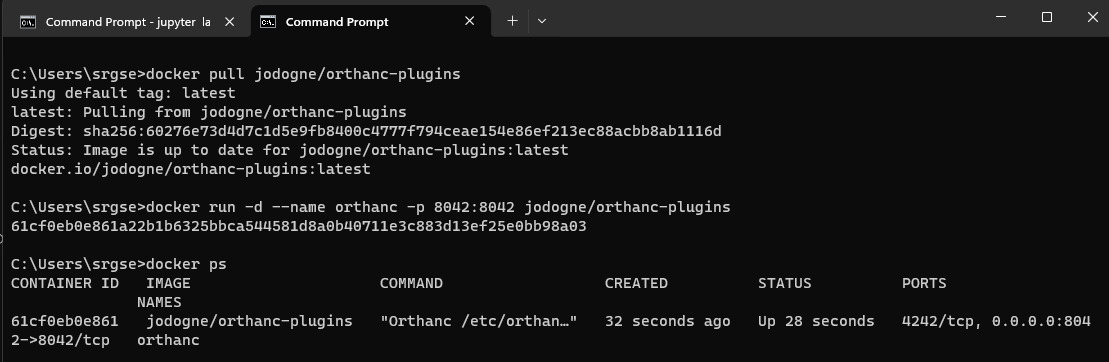

In [2]:
display(Image(filename='Documentos/cmd.jpeg'))

Depois desses passos, estou habilitado a utilizar o host local em `http://localhost:8042`.

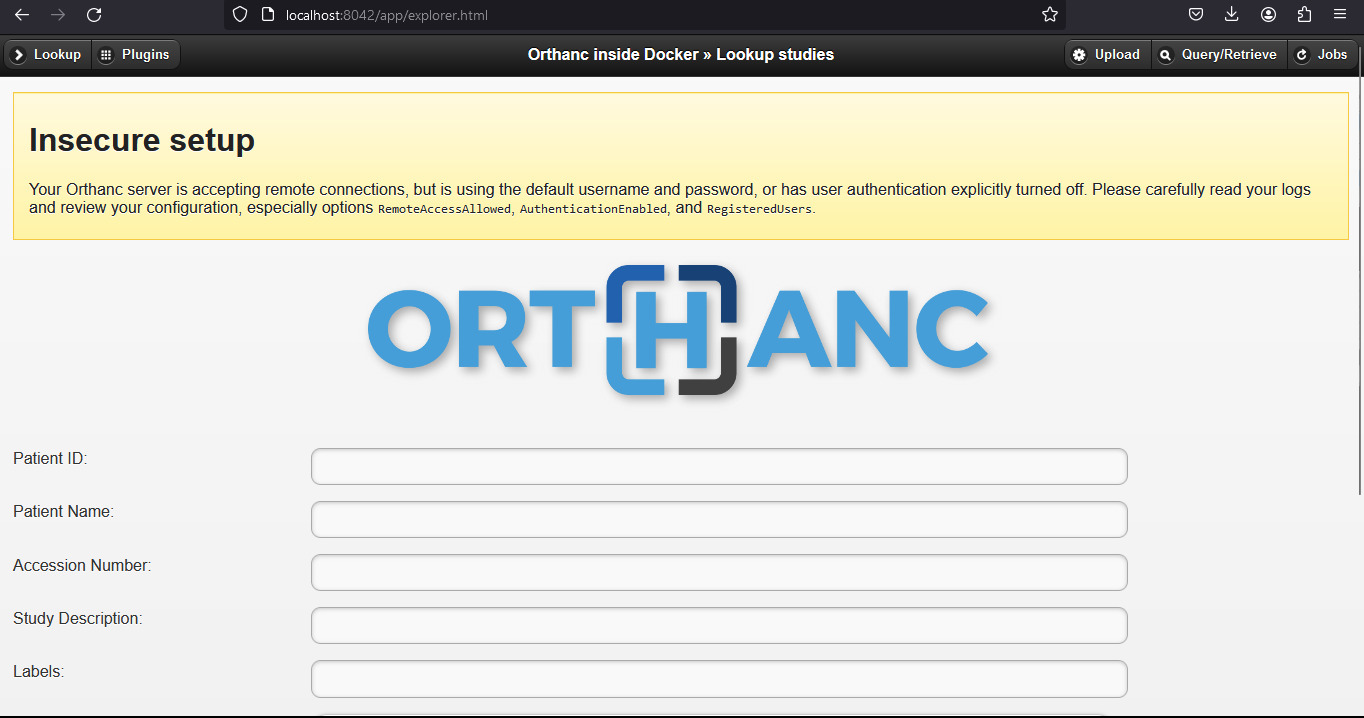

In [3]:
display(Image(filename='Documentos/orthanc.jpeg'))

Ao entrar em casos de estudo consigo identificar o primeiro caso de estudo. (Upload feito pelo cmd no primeiro passo)

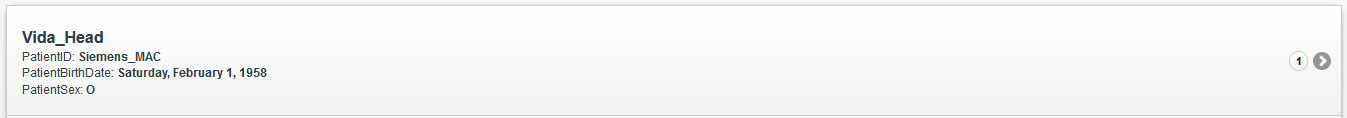

In [4]:
display(Image(filename='Documentos/primeira_imagem.jpeg'))

## 2) Envio

Aqui fiz o upload das imagens como instâncias. O código a seguir itera pelas arquivos dcm requisitados do desafio e envia para o servidor local. Todas encontram-se na pasta `Imagens_dicom`. 

In [5]:
# Define the path to the folder
folder_path = 'Imagens_dicom'

# Iterate over the files in the folder
for file_name in os.listdir(folder_path):
    # Create the full path to the file
    file_path = os.path.join(folder_path, file_name)
    
    # Check if it's a file
    if os.path.isfile(file_path):
    # Prepare the image:
        path = 'Imagens_dicom/' + file_name
        print(f' Enviando o seguinte arquivo DICOM: {file_name}')
        
        # OrthanC'S URL
        orthanc_url = "http://localhost:8042/instances"

        # DICOM file path
        dicom_file = path

        # Open and send file
        with open(dicom_file, 'rb') as f:
            files = {'file': f}
            response = requests.post(orthanc_url, files=files, auth=HTTPBasicAuth('orthanc', 'orthanc'))

        # Checking response
        print(response.status_code)
        print(response.text)

 Enviando o seguinte arquivo DICOM: image-09599604-82254875-28128815-63496762-37337175.dcm
200

 Enviando o seguinte arquivo DICOM: image-15261899-16336799-16570287-29657437-32481398.dcm
200

 Enviando o seguinte arquivo DICOM: image-15908848-77237609-03232560-96641664-72033662.dcm
200

 Enviando o seguinte arquivo DICOM: image-23691574-78007127-67077450-08256882-87395367.dcm
200

 Enviando o seguinte arquivo DICOM: image-37893342-90788293-97674894-30563722-15937211.dcm
200

 Enviando o seguinte arquivo DICOM: image-43591434-24105909-95501830-31186664-56232345.dcm
200

 Enviando o seguinte arquivo DICOM: image-49456968-50961677-93916823-30114741-97249659.dcm
200

 Enviando o seguinte arquivo DICOM: image-75545339-55870039-51885816-92064157-98378507.dcm
200

 Enviando o seguinte arquivo DICOM: image-77089611-78785961-69826278-95000740-26294623.dcm
200



Uma forma de conferir sem ter que sair do script do python, é confirmando as respostas do protocolo html em relação as ID's de cada arquivo. O número `200` que apareceu anteriormente indica um resultado de sucesso do envio. Portanto, ao checar esse número conseguimos averiguar a existência do arquivo. O código abaixo faz exatamente isso.

In [6]:
# URL to list all instances in Orthanc
orthanc_url = "http://localhost:8042/instances"

# Making a GET request to fetch the list of instances
response = requests.get(orthanc_url, auth=HTTPBasicAuth('orthanc', 'orthanc'))

# Verifying the response
if response.status_code == 200:
    instances = response.json()  # List of instance IDs
    print("Uploaded instances:", instances)
else:
    print("Error:", response.status_code, response.text)

Uploaded instances: ['f816ed6a-8177f2bc-53267934-dc56e141-86749fb2', '76a9a673-cdfbc0e8-efa364cc-27c25423-aad7ec6c', '25cc82b9-38583a9e-8a08fc15-f4892024-28b8584b', '1f2d2901-0e995924-103fdbf4-8aacb8be-4279c8da', '1a368e54-0a0a28a0-c5be7bc2-8a4c7492-aa9d3468', '89713983-98986f53-c67e566f-6786c944-1697687d', '8206ee5f-8f834b42-042e6a40-705b72da-bc7ce3a3', 'b8eaee70-ed5ace3a-2f77895e-8105e3d3-ec3508ce', '70d0117e-60d4002b-cbbe9042-3b57555a-e88bfd99']


Conferindo também no servidor!

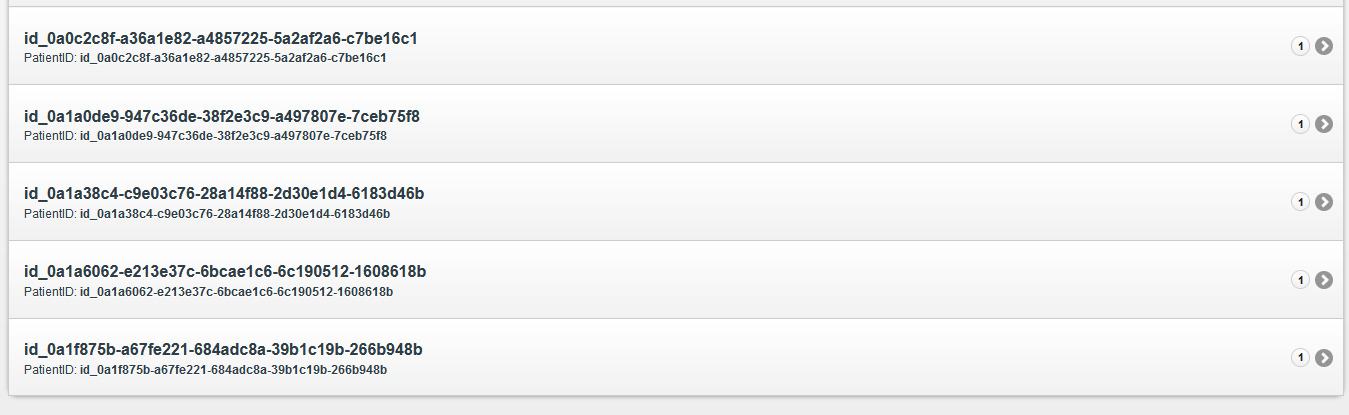

In [7]:
display(Image(filename='Documentos/imagens_escolhidas.jpeg'))

## 3) Predição

Implementando a função que foi fornecida no desafio para leitura correta do arquivo `.dcm` antes de fazer a predição no modelo pré-treinado.

In [8]:
def read_xray_dcm(path: os.PathLike) -> ndarray:
    """read a dicom-like file and convert to numpy array 

    Args:
        path (PathLike): path to the dicom file

    Returns:
        ndarray: 2D single array image for a dicom image scaled between -1024, 1024
    """
    try:
        import pydicom
    except ImportError:
        raise Exception("Missing Package Pydicom. Try installing it by running pip install pydicom.")

    # get the pixel array
    ds = pydicom.dcmread(path, force=True)

    # we have not tested RGB, YBR_FULL, or YBR_FULL_422 yet.
    if ds.PhotometricInterpretation not in ['MONOCHROME1', 'MONOCHROME2']:
        raise NotImplementedError(f'PhotometricInterpretation {ds.PhotometricInterpretation} is not yet supported.')

    data = ds.pixel_array
    
    # LUT for human friendly view
    data = pydicom.pixel_data_handlers.util.apply_voi_lut(data, ds, index=0)

    # MONOCHROME1 have an inverted view; Bones are black; background is white
    # https://web.archive.org/web/20150920230923/http://www.mccauslandcenter.sc.edu/mricro/dicom/index.html
    if ds.PhotometricInterpretation == "MONOCHROME1":
        warnings.warn(f"Coverting MONOCHROME1 to MONOCHROME2 interpretation for file: {path}. Can be avoided by setting fix_monochrome=False")
        data = data.max() - data

    # normalize data to [-1024, 1024]
    data = normalize(data, data.max())
    return data

Fazendo o teste inicial para apenas uma imagem enviada para estudar o resultado.

In [9]:
# Prepare the image:
path = "Imagens_dicom/image-15261899-16336799-16570287-29657437-32481398.dcm"
img =  read_xray_dcm(path)
img = img[None, ...]
#img = img.mean(2)[None, ...] # Make single color channel

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

img = transform(img)
img = torch.from_numpy(img)

# Load model and process image
model = xrv.models.DenseNet(weights="densenet121-res224-all")
outputs = model(img[None,...]) # or model.features(img[None,...]) 

# Print results
dict(zip(model.pathologies,outputs[0].detach().numpy()))

{'Atelectasis': 0.10820826,
 'Consolidation': 0.073591545,
 'Infiltration': 0.528651,
 'Pneumothorax': 0.03061236,
 'Edema': 0.0038531895,
 'Emphysema': 0.020751815,
 'Fibrosis': 0.08495864,
 'Effusion': 0.031601105,
 'Pneumonia': 0.00461805,
 'Pleural_Thickening': 0.04244853,
 'Cardiomegaly': 0.21898803,
 'Nodule': 0.4212189,
 'Mass': 0.14383975,
 'Hernia': 0.00047964312,
 'Lung Lesion': 0.010462529,
 'Fracture': 0.16109543,
 'Lung Opacity': 0.05661427,
 'Enlarged Cardiomediastinum': 0.06395575}

Agora implementei funções para automatizar o processo de leitura das imagens e fazer a predição de acordo com essas. Para mais detalhes, leia a docstring. 

In [10]:
def process_dicom(file_name, folder_path='Imagens_dicom'):
    """
    Processes a specific DICOM file, applies transformations, and uses a model to predict pathologies.

    Args:
        file_name (str): The name of the DICOM file to be processed.
        folder_path (str): The path to the folder where the DICOM file is located.

    Returns:
        dict: A dictionary with predicted pathologies and their respective number predictions.
        
    Raises:
        FileNotFoundError: If the DICOM file is not found at the specified path.
    """
    # Create the full path to the file
    file_path = os.path.join(folder_path, file_name)
    print(file_path)
    
    # Check if the file exists
    if os.path.isfile(file_path):
        print(f'Predição para a imagem: {file_name}')
        
        # Prepare the image
        img = read_xray_dcm(file_path)
        img = img[None, ...]
        
        # Apply transformations
        transform = torchvision.transforms.Compose([
            xrv.datasets.XRayCenterCrop(),
            xrv.datasets.XRayResizer(224)
        ])
        
        img = transform(img)
        img = torch.from_numpy(img)
        
        # Load model and process image
        model = xrv.models.DenseNet(weights="densenet121-res224-all")
        outputs = model(img[None, ...]) # or model.features(img[None, ...])
        
        # Return results as a dictionary
        result = dict(zip(model.pathologies, outputs[0].detach().numpy()))
        return result
    else:
        raise FileNotFoundError(f'The file {file_name} was not found at the path {folder_path}.')

def process_all_dicom_files(folder_path='Imagens_dicom'):
    """
    Processes all DICOM files in a folder and returns predictions for each.

    Args:
        folder_path (str): The path to the folder containing the DICOM files (default is 'Imagens_dicom').

    Returns:
        dict: A dictionary with prediction results for each DICOM file, where the keys are file names and the values are dictionaries with predicted pathologies.
    """
    predictions = {}  # Dictionary to store results for each DICOM file
    
    # Iterate over the files in the folder
    for file_name in os.listdir(folder_path):
        # Create the full path to the file
        file_path = os.path.join(folder_path, file_name)
        
        # Check if it's a file
        if os.path.isfile(file_path):
            # Process the DICOM file
            result = process_dicom(file_name, folder_path)
            
            # Store the result in the dictionary
            predictions[file_name] = result
            print(f'Predictions for {file_name}: {result}')
            print('\n')
    
    return predictions

# Example of calling the function
all_predictions = process_all_dicom_files()

Imagens_dicom\image-09599604-82254875-28128815-63496762-37337175.dcm
Predição para a imagem: image-09599604-82254875-28128815-63496762-37337175.dcm
Predictions for image-09599604-82254875-28128815-63496762-37337175.dcm: {'Atelectasis': 0.5175103, 'Consolidation': 0.5020342, 'Infiltration': 0.5068253, 'Pneumothorax': 0.5005156, 'Edema': 0.082646884, 'Emphysema': 0.5009453, 'Fibrosis': 0.31129318, 'Effusion': 0.21513818, 'Pneumonia': 0.10813412, 'Pleural_Thickening': 0.22150312, 'Cardiomegaly': 0.3345644, 'Nodule': 0.5061434, 'Mass': 0.53252006, 'Hernia': 0.17188053, 'Lung Lesion': 0.01843406, 'Fracture': 0.5248085, 'Lung Opacity': 0.57850516, 'Enlarged Cardiomediastinum': 0.50240517}


Imagens_dicom\image-15261899-16336799-16570287-29657437-32481398.dcm
Predição para a imagem: image-15261899-16336799-16570287-29657437-32481398.dcm
Predictions for image-15261899-16336799-16570287-29657437-32481398.dcm: {'Atelectasis': 0.10820826, 'Consolidation': 0.073591545, 'Infiltration': 0.528651, 'P

### Transformando em `.json`

Primeiramente foi necessário alguns ajustes nos dados antes de fato converter para `.json` então implementei uma função de ajuste e outra de conversão, respectivamente.

In [11]:
import json
import numpy as np

def convert_to_serializable(obj):
    """
    Converts objects like float32 to standard Python types
    to make them JSON serializable.
    """
    if isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    else:
        return obj

def save_json(predictions, output_file='predições.json'):
    """
    Saves the predictions dictionary as a JSON file, after ensuring
    all values are JSON serializable.
    
    Args:
        predictions (dict): The predictions dictionary to save.
        output_file (str): The name of the output JSON file.
    """
    serializable_predictions = convert_to_serializable(predictions)
    
    with open(output_file, 'w') as json_file:
        json.dump(serializable_predictions, json_file, indent=4)
    print(f'Resultado salvo em: {output_file}')

# Salva as predições no arquivo JSON
save_json(all_predictions)

Resultado salvo em: predições.json


## 4) Extra

Agora para fazer o `Structured Report (SR)`  também implementei uma função, ela aproveita da variável `all_predictions` que é resultado da função anterior. Assim, consegui implementar o relatório de acordo com o paciente.

In [12]:
def dicom_sr(original_dicom, results_dict):
    """
    Creates a Structured Report (SR) DICOM dataset based on the original DICOM file and model results.

    Args:
        original_dicom (Dataset): The original DICOM dataset from which patient and study information is copied.
        results_dict (dict): A dictionary containing the model results to be included in the SR. Keys are the types of results, and values are the corresponding values.

    Returns:
        Dataset: A new DICOM dataset representing the Structured Report with the provided results.
    """
    # Create an empty dataset for the SR
    sr = Dataset()

    # Main patient information (copied from the original)
    sr.PatientName = original_dicom.PatientName
    sr.PatientID = original_dicom.PatientID
    sr.StudyInstanceUID = original_dicom.StudyInstanceUID
    sr.SeriesInstanceUID = generate_uid()  # Creating a new Series UID for the SR
    sr.SOPInstanceUID = generate_uid()  # Unique identifier for the SR
    sr.SOPClassUID = pydicom.uid.RTStructureSetStorage  # UID specific to SR

    # Date and time
    sr.ContentDate = datetime.now().strftime('%Y%m%d')
    sr.ContentTime = datetime.now().strftime('%H%M%S')

    # Modality
    sr.Modality = 'SR'
    
    # Basic report information
    sr.ValueType = 'CONTAINER'
    sr.ConceptNameCodeSequence = [Dataset()]
    sr.ConceptNameCodeSequence[0].CodingSchemeDesignator = 'SR'
    sr.ConceptNameCodeSequence[0].CodeMeaning = 'Structured Report'
    
    # Model results (each entry from the dictionary)
    sr.ContentSequence = []
    for key, value in results_dict.items():
        item = Dataset()
        item.ValueType = key
        item.TextValue = str(value)  # Model result value
        sr.ContentSequence.append(item)

    # Define the VR as Explicit Little Endian
    sr.is_little_endian = True
    sr.is_implicit_VR = False
    sr.file_meta = Dataset()
    sr.file_meta.TransferSyntaxUID = ExplicitVRLittleEndian
    sr.file_meta.MediaStorageSOPClassUID = sr.SOPClassUID
    sr.file_meta.MediaStorageSOPInstanceUID = sr.SOPInstanceUID

    return sr

Armazenando a imagem e o resultado em duas variáveis.

In [13]:
all_images = list(all_predictions.keys())
all_dics = list(all_predictions.values())

Salvando as imagens com seus respectivos `SR` e um arquivo `.dcm`.

In [14]:
# Process the files
for i in range(len(all_images)):
    # Load the original DICOM and the model results
    dicom_file_path = os.path.join('Imagens_dicom', all_images[i])
    original_dicom = pydicom.dcmread(dicom_file_path)
    results_dict = all_dics[i]

    # Create the SR
    DICOM_SR = dicom_sr(original_dicom, results_dict)

    # Generate the correct path to save the SR, without duplicating the ".dcm" extension
    sr_file_name = "sr_" + all_images[i]  # Use the original file name, prefixed with "sr_"
    sr_file_path = os.path.join('SR', sr_file_name)  # Generate the full path

    # Save the SR to a file
    DICOM_SR.save_as(sr_file_path)

Enviando os resultados `SR` para o servidor.

In [15]:
# Define the path to the folder
folder_path = 'SR'

# Iterate over the files in the folder
for file_name in os.listdir(folder_path):
    # Create the full path to the file
    file_path = os.path.join(folder_path, file_name)
    
    # Check if it's a file
    if os.path.isfile(file_path):
    # Prepare the image:
        path = 'SR/' + file_name
        print(f' Enviando o seguinte arquivo DICOM: {file_name}')
        
        # OrthanC'S URL
        orthanc_url = "http://localhost:8042/instances"

        # DICOM file path
        dicom_file = path

        # Open and send file
        with open(dicom_file, 'rb') as f:
            files = {'file': f}
            response = requests.post(orthanc_url, files=files, auth=HTTPBasicAuth('orthanc', 'orthanc'))

        # Verificando a resposta
        print(response.status_code)
        print(response.text)

 Enviando o seguinte arquivo DICOM: sr_image-09599604-82254875-28128815-63496762-37337175.dcm
200

 Enviando o seguinte arquivo DICOM: sr_image-15261899-16336799-16570287-29657437-32481398.dcm
200

 Enviando o seguinte arquivo DICOM: sr_image-15908848-77237609-03232560-96641664-72033662.dcm
200

 Enviando o seguinte arquivo DICOM: sr_image-23691574-78007127-67077450-08256882-87395367.dcm
200

 Enviando o seguinte arquivo DICOM: sr_image-37893342-90788293-97674894-30563722-15937211.dcm
200

 Enviando o seguinte arquivo DICOM: sr_image-43591434-24105909-95501830-31186664-56232345.dcm
200

 Enviando o seguinte arquivo DICOM: sr_image-49456968-50961677-93916823-30114741-97249659.dcm
200

 Enviando o seguinte arquivo DICOM: sr_image-75545339-55870039-51885816-92064157-98378507.dcm
200

 Enviando o seguinte arquivo DICOM: sr_image-77089611-78785961-69826278-95000740-26294623.dcm
200



Os resultados podem ser vistos da seguinte maneira:

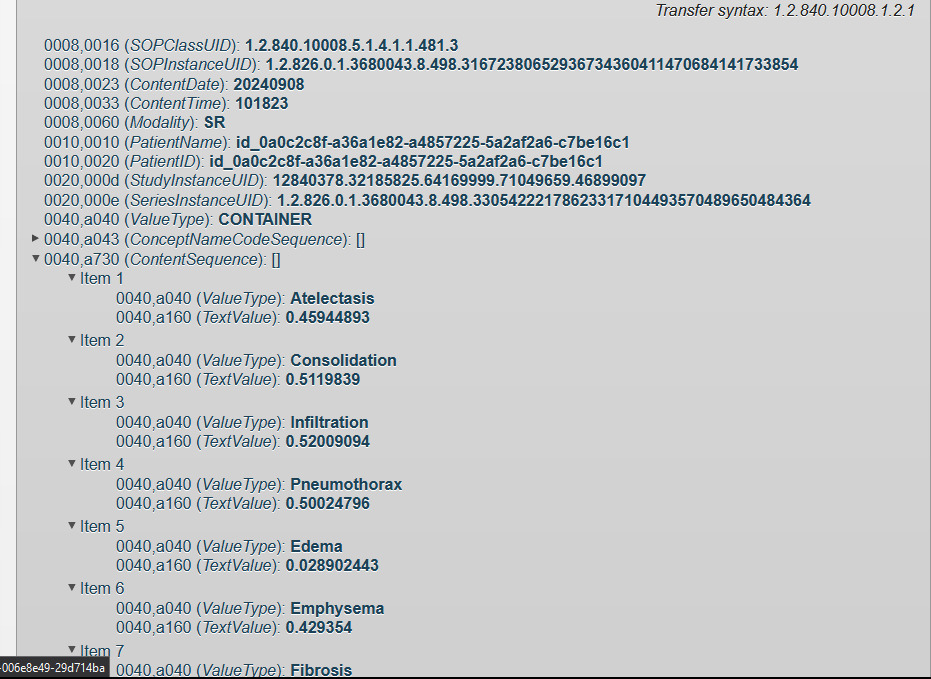

In [16]:
display(Image(filename='Documentos/resultados.jpeg'))